# LSGAN

- paper : https://arxiv.org/abs/1611.04076
- implementation
    - torch : https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/lsgan/lsgan.py
    - tf : https://github.com/xudonmao/LSGAN

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import LSUN

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import time

torch.manual_seed(999)

In [2]:
data_dir = "data/lsun"
save_dir = "result/lsgan"
img_classes = ["bedroom_train"]
workers = 2
epochs = 20
batch_size = 256
image_size = 112
nc = 3
nz = 1024
ngf = 64
ndf = 64
lr = 0.001
beta1 = 0.5
image_list_freq = 500
device = "cuda:0"
indent = "    "

## Dataset

In [3]:
dataset = LSUN(
    root=data_dir,
    classes=img_classes,
    transform=transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

### Image preview

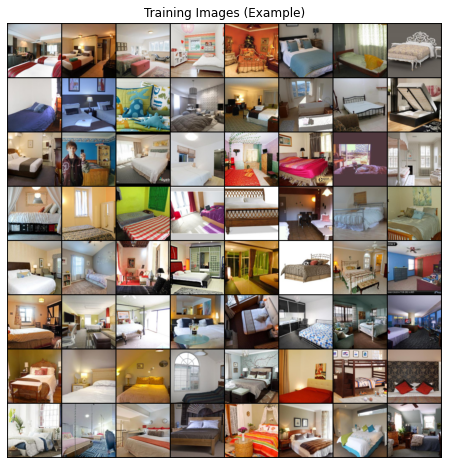

In [4]:
batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images (Example)")
plt.imshow(np.transpose(make_grid(batch[0][:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

## Models : Generator, Discriminator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.block1 = self._first_block(
            in_features=nz,
            out_features=(ngf*4)*(image_size//16)*(image_size//16)
        )
        self.block2_1 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block2_2 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block3_1 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block3_2 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*4),
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block4 = self._block(
            in_channels=(ngf*4),
            out_channels=(ngf*2),
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block5 = self._block(
            in_channels=(ngf*2),
            out_channels=ngf,
            kernel_size=3,
            stride=2,
            padding=1
        )
        self.block6 = self._last_block(
            in_channels=ngf,
            out_channels=nc,
            kernel_size=3,
            stride=1,
            padding=1
        )

    def _first_block(self, in_features, out_features, bias=True):
        return nn.Sequential(
            nn.Linear(
                in_features=in_features,
                out_features=out_features,
                bias=bias,
            ),
            nn.BatchNorm1d(
                num_features=out_features
            ),
            nn.ReLU(
                inplace=True
            )
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=(stride + 2 * padding - kernel_size),
                bias=bias
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.ReLU(
                inplace=True
            )
        )
    
    def _last_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                output_padding=(stride + 2 * padding - kernel_size),
                bias=bias
            ),
            nn.Tanh()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nz=1024, 1, 1]
        batch_size = x.shape[0]
        
        out = x.view(batch_size, -1)
        # out : [batch, channel * h * w] = [batch, nz=1024]
        
        out = self.block1(out).view(batch_size, ngf * 4, image_size // 16, image_size // 16)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/16=7, image_size/16=7]
        
        out = self.block2_1(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block2_2(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block3_1(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/4=28, image_size/4=28]
        
        out = self.block3_2(out)
        # out : [batch, channel, h, w] = [batch, ngf*4=256, image_size/4=28, image_size/4=28]
        
        out = self.block4(out)
        # out : [batch, channel, h, w] = [batch, ngf*2=128, image_size/2=56, image_size/2=56]
        
        out = self.block5(out)
        # out : [batch, channel, h, w] = [batch, ngf=64, image_size=112, image_size=112]
        
        out = self.block6(out)
        # out : [batch, channel, h, w] = [batch, nc=3, image_size=112, image_size=112]
        return out

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block1 = self._first_block(
            in_channels=nc,
            out_channels=ndf,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block2 = self._block(
            in_channels=ndf,
            out_channels=ndf * 2,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block3 = self._block(
            in_channels=ndf * 2,
            out_channels=ndf * 4,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block4 = self._block(
            in_channels=ndf * 4,
            out_channels=ndf * 8,
            kernel_size=5,
            stride=2,
            padding=2
        )
        self.block5 = self._last_block(
            in_features=((ndf * 8) * (image_size // 16) * (image_size // 16)),
            out_features=1
        )
        
    def _first_block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding, bias=True):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=bias                
            ),
            nn.BatchNorm2d(
                num_features=out_channels
            ),
            nn.LeakyReLU(
                negative_slope=0.2,
                inplace=True
            )
        )
    
    def _last_block(self, in_features, out_features, bias=True):
        return nn.Sequential(
            nn.Linear(
                in_features=in_features,
                out_features=out_features,
                bias=bias
            ),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x : [batch, channel, h, w] = [batch, nc=3, image_size=112, image_size=112]
        batch_size = x.shape[0]
        
        out = self.block1(x)
        # out : [batch, channel, h, w] = [batch, ndf=64, image_size/2=56, image_size/2=56]
        
        out = self.block2(out)
        # out : [batch, channel, h, w] = [batch, ndf*2=128, image_size/4=28, image_size/4=28]
        
        out = self.block3(out)
        # out : [batch, channel, h, w] = [batch, ndf*4=256, image_size/8=14, image_size/8=14]
        
        out = self.block4(out)
        # out : [batch, channel, h, w] = [batch, ndf*8=512, image_size/16=7, image_size/16=7]
        
        out = self.block5(out.view(batch_size, -1)).view(batch_size, 1, 1, 1)
        # out : [batch, channel, h, w] = [batch, 1, 1, 1]
        return out

In [7]:
#z = torch.randn([batch_size, nz, 1, 1]).to(device)
#g = Generator().to(device)
#g(z)

## Training

In [8]:
def init_weights(module):
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [9]:
netG = Generator().to(device)
netG.apply(init_weights)
print(netG)

netD = Discriminator().to(device)
netD.apply(init_weights)
print(netD)

Generator(
  (block1): Sequential(
    (0): Linear(in_features=1024, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2_1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2_2): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3_1): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block3_2): Sequential(
  

In [10]:
criterion = nn.MSELoss()

fixed_noise = torch.randn(64, nz, 1, 1).to(device)

REAL_LABEL = 1
FAKE_LABEL = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"Epoch {epoch + 1:3}/{epochs:3}")
    
    epoch_G_loss = 0
    epoch_D_loss = 0
    
    for i, data in enumerate(dataloader):
        batch_start_time = time.time()
        
        # 1. Update D
        netD.zero_grad()
        
        ## Train with all-real batch
        real_examples = data[0].to(device)
        real_labels = torch.full((real_examples.shape[0],), REAL_LABEL).float().to(device)
        
        real_output = netD(real_examples).flatten()
        real_loss = criterion(real_output, real_labels)
        #real_loss.backward()

        D_x = real_output.mean().item()
        
        ## Train with all-fake batch
        zs = torch.randn(batch_size, nz, 1, 1).to(device)
        fake_examples = netG(zs)
        fake_labels = torch.full((fake_examples.shape[0],), FAKE_LABEL).float().to(device)
        
        fake_output = netD(fake_examples.clone().detach()).flatten()
        fake_loss = criterion(fake_output, fake_labels)
        #fake_loss.backward()
        
        D_G_z1 = fake_output.mean().item()
        
        ## update D params
        D_loss = 0.5 * (real_loss + fake_loss)
        D_loss.backward()
        optimizerD.step()
        
        # 2. Update G
        netG.zero_grad()
        
        G_labels = torch.full((fake_examples.shape[0],), REAL_LABEL).float().to(device)
        
        G_output = netD(fake_examples).flatten()
        G_loss = 0.5 * criterion(G_output, G_labels)
        G_loss.backward()
        
        D_G_z2 = G_output.mean().item()
        
        ## update G params
        optimizerG.step()
        
        # 3. Etc
        ## print logs
        if i % 50 == 0:
            print(f'{indent * 2}Iter {i:4}/{len(dataloader):4} [{time.time() - batch_start_time:.4f}s] \t D_loss: {D_loss.item():8.4f} | G_loss: {G_loss.item():8.4f} | D(x): {D_x:8.4f} | D(G(z)): {D_G_z1:8.4f} / {D_G_z2:8.4f}')

        ## save losses for plotting later
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        epoch_G_loss += G_loss.item()
        epoch_D_loss += D_loss.item()

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % image_list_freq == 0) or ((epoch == epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_examples = netG(fixed_noise).detach().cpu()
            img_list.append(make_grid(fake_examples, padding=2, normalize=True))
        iters += 1
    
    epoch_elapsed_time = time.time() - epoch_start_time
    print(f"{indent}D_loss: {epoch_D_loss / len(dataloader):8.4f} [{epoch_elapsed_time // 60}m {epoch_elapsed_time % 60:.4f}s] \tG_loss: {epoch_G_loss / len(dataloader):8.4f}")

Epoch   1/ 20
        Iter    0/11848 [0.3982s] 	 D_loss:   0.2640 | G_loss:   0.5000 | D(x):   0.5127 | D(G(z)):   0.5239 /   0.0000
        Iter   50/11848 [0.3147s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   0.9999 | D(G(z)):   1.0000 /   1.0000
        Iter  100/11848 [0.3106s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   0.9999 | D(G(z)):   1.0000 /   1.0000
        Iter  150/11848 [0.3095s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
        Iter  200/11848 [0.3142s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
        Iter  250/11848 [0.3137s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
        Iter  300/11848 [0.3107s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
        Iter  350/11848 [0.3096s] 	 D_loss:   0.5000 | G_loss:   0.0000 | D(x):   1.0000 | D(G(z)):   1.0000 /   1.0000
        Iter  400/11848 [0

## Result

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
!mkdir -p {savedir}

with torch.no_grad():
    fake_examples = np.transpose(netG(fixed_noise).detach().cpu().numpy(), (0, 2, 3, 1))
    for i, example in enumerate(fake_examples, 1):
        Image.fromarray((example * 255).astype(np.uint8)).save(os.path.join(savedir, f"dcgan-{i:02d}.png"))